In [2]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [3]:
train_x_df = pd.read_csv("train_x_df.csv", encoding = 'utf-8')

In [22]:
train_y_df = pd.read_csv("train_y_df.csv", encoding = 'utf-8')

In [3]:
train_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
10572175,7660,1375,8,1.000277,1.000499,1.000000,1.000388,0.574281,103.592369,0.665410,0.266649,48.100475
10572176,7660,1376,8,1.000333,1.000388,0.999834,1.000277,1.350429,243.535217,0.804037,0.487857,87.985291
10572177,7660,1377,8,1.000277,1.000388,0.999834,1.000277,0.692170,124.846756,0.781857,0.360461,65.018936
10572178,7660,1378,8,1.000166,1.000222,0.999778,1.000056,0.556481,100.351929,0.670955,0.296588,53.486565


In [4]:
train_x_df.columns  # column명을 출력.

Index(['sample_id', 'time', 'coin_index', 'open', 'high', 'low', 'close',
       'volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av'],
      dtype='object')

In [5]:
train_x_df.head() # 상위 5행만 출력, argument:index는 최대 몇행 출력할지를 의미.

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [6]:
train_x_df.describe()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
count,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07,1.057218e+07
mean,3.830000e+03,6.895000e+02,5.456729e+00,1.000650e+00,1.001450e+00,9.998227e-01,1.000642e+00,7.761177e+05,4.792650e+04,1.261575e+02,3.706698e+05,2.368729e+04
std,2.211540e+03,3.983716e+02,2.943867e+00,4.027305e-02,4.032254e-02,4.022103e-02,4.024325e-02,9.201730e+06,2.461396e+05,5.192760e+02,5.188063e+06,1.279145e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,8.903663e-02,5.540227e-01,8.903663e-02,5.540227e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.915000e+03,3.447500e+02,4.000000e+00,9.865683e-01,9.873150e-01,9.858038e-01,9.865824e-01,6.036940e-02,3.364670e+01,8.322930e-02,6.927575e-03,1.156383e+01
50%,3.830000e+03,6.895000e+02,6.000000e+00,1.000000e+00,1.000500e+00,9.993641e-01,9.999900e-01,3.708659e+00,3.692633e+02,8.632804e-01,1.167656e+00,1.318855e+02
75%,5.745000e+03,1.034250e+03,8.000000e+00,1.012913e+00,1.013659e+00,1.012141e+00,1.012891e+00,4.461639e+04,1.351256e+04,5.891339e+01,9.740486e+03,5.306334e+03
max,7.660000e+03,1.379000e+03,9.000000e+00,2.066901e+00,4.451831e+00,2.066901e+00,2.066901e+00,7.398036e+09,4.957759e+07,6.257862e+04,7.340513e+09,2.320023e+07


In [ ]:
train_x_df.iloc[[0,1,2,3], [1,3,4]]  #[[행],[열]], 연속된것이아니라 개별 열을 불러오는것

In [7]:
train_x_df.loc[:1379, :]

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0,1375,9,0.999015,0.999388,0.998400,0.998400,0.002577,20.899395,0.017492,0.001371,11.117771
1376,0,1376,9,0.998400,0.999260,0.998400,0.999016,0.001256,10.188805,0.011333,0.000556,4.510879
1377,0,1377,9,0.999018,0.999629,0.998936,0.999629,0.002902,23.543552,0.014289,0.001761,14.289263
1378,0,1378,9,0.999629,1.000116,0.999143,1.000000,0.004383,35.568905,0.020941,0.002810,22.806458


In [8]:
sample_0 = train_x_df[train_x_df['sample_id'] == 0]
sample_0

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0,1375,9,0.999015,0.999388,0.998400,0.998400,0.002577,20.899395,0.017492,0.001371,11.117771
1376,0,1376,9,0.998400,0.999260,0.998400,0.999016,0.001256,10.188805,0.011333,0.000556,4.510879
1377,0,1377,9,0.999018,0.999629,0.998936,0.999629,0.002902,23.543552,0.014289,0.001761,14.289263
1378,0,1378,9,0.999629,1.000116,0.999143,1.000000,0.004383,35.568905,0.020941,0.002810,22.806458


In [9]:
sample_group = train_x_df.groupby('sample_id')

In [10]:
open_mean = sample_group['open'].mean()
high_mean = sample_group['high'].mean()
high_std = sample_group['high'].std()
low_mean = sample_group['low'].mean()
low_std = sample_group['low'].std()

In [11]:
sample_group.get_group(0)


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0,1375,9,0.999015,0.999388,0.998400,0.998400,0.002577,20.899395,0.017492,0.001371,11.117771
1376,0,1376,9,0.998400,0.999260,0.998400,0.999016,0.001256,10.188805,0.011333,0.000556,4.510879
1377,0,1377,9,0.999018,0.999629,0.998936,0.999629,0.002902,23.543552,0.014289,0.001761,14.289263
1378,0,1378,9,0.999629,1.000116,0.999143,1.000000,0.004383,35.568905,0.020941,0.002810,22.806458


In [12]:
y = sample_group.get_group(0)['high'] - sample_group.get_group(0)['low']
y2 = sample_group.get_group(0)['quote_av']
y3 = sample_group.get_group(0)['tb_quote_av']
x = sample_group.get_group(0)['time']

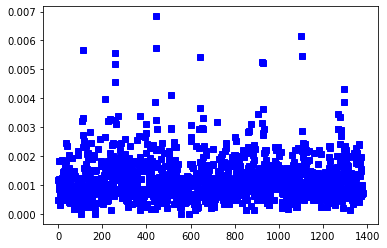

In [13]:
plt.plot(x,y,'bs')

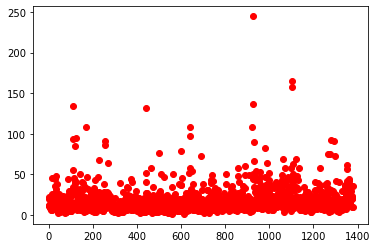

In [14]:
plt.plot(x,y2,'ro')

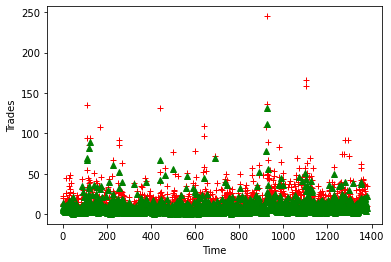

In [15]:
plt.plot(x,y2,'r+', label = 'Quote_av')
plt.plot(x,y3,'g^', label= 'Tb_quote_av')
plt.xlabel("Time")
plt.ylabel("Trades")
plt.show()

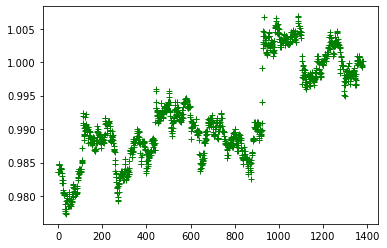

In [16]:
z = sample_group.get_group(0)['high']
z1 = sample_group.get_group(0)['low']
plt.plot(x,z,'g+', label = 'High')

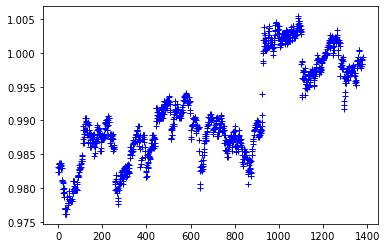

In [17]:
plt.plot(x,z1,'b+', label = 'low')

In [29]:
quote_av = sample_group.get_group(0)['quote_av'].loc[800:950]
tb_quote_av = sample_group.get_group(0)['tb_quote_av'].loc[800:950]
time = sample_group.get_group(0)['time'].loc[800:950]

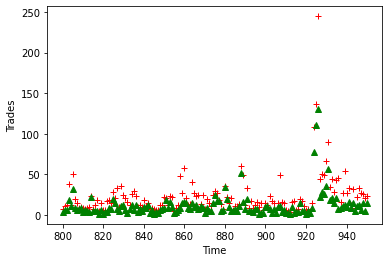

In [30]:
plt.plot(time,quote_av,'r+', label = 'Quote_av')
plt.plot(time,tb_quote_av,'g^', label= 'Tb_quote_av')
plt.xlabel("Time")
plt.ylabel("Trades")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

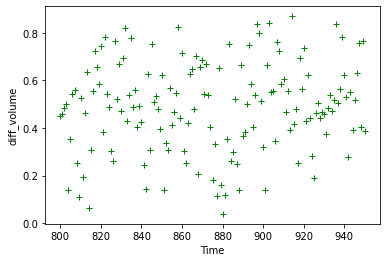

In [34]:
plt.plot(time, diff, 'g+', label = 'diff')
plt.xlabel("Time")
plt.ylabel("diff_volume")
plt.show

In [35]:
quote_av = sample_group.get_group(0)['quote_av'].loc[1050:1150]
tb_quote_av = sample_group.get_group(0)['tb_quote_av'].loc[1050:1150]
time = sample_group.get_group(0)['time'].loc[1050:1150]

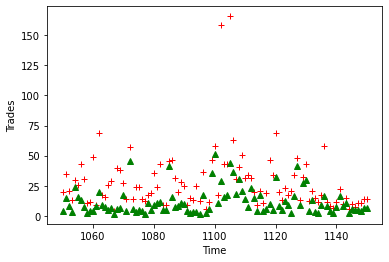

In [36]:
plt.plot(time,quote_av,'r+', label = 'Quote_av')
plt.plot(time,tb_quote_av,'g^', label= 'Tb_quote_av')
plt.xlabel("Time")
plt.ylabel("Trades")
plt.show()

In [4]:
coin_group = train_x_df.groupby('coin_index')

In [9]:
coin_9 = coin_group.get_group(9)

In [20]:
sample_coin9 = coin_9.groupby('sample_id').size()

In [21]:
sample_coin9[:10]

sample_id
0     1380
1     1380
9     1380
17    1380
18    1380
21    1380
24    1380
27    1380
28    1380
37    1380
dtype: int64